In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian
import numpy
import scipy

In [3]:
d_ = 2
l = 300
np.random.seed(612635)
true_weights = np.array([-9, 15])

noise = 2

d = np.random.rand(l)
ones = np.ones((d.shape[0], 1))
d = np.concatenate((np.reshape(d, (d.shape[0], 1)), ones), axis=1)
y = np.random.normal(loc = 0, scale=2, size=l).reshape([l, 1]) + true_weights[0] * d[:, 0].reshape([l,1]) + true_weights[1] # Linear function with slope 1 added noise epsilon
mean_prior = np.array([0.0, 0.0])
A_prior = np.array([[0.9, 0.3], [0.3, -3.0]])

In [3]:
#def log_likelihood(mu, A):
#    N = 100
#    values = []
#    for i in range(N):
#        z = np.random.normal(loc=0, scale=1, size=mu.shape)
#        theta = mu + A @ z
#    values.append(np.array([theta]))
#    return np.log(1/N * np.sum(values))

#log_likelihood(np.array([1, 2]), np.array([[2,3], [4,5]]))

In [4]:
def log_likelihood(y, theta, d):
    #print(theta.T @ d.T)
    likelihood_cov = np.mean(np.square(y.T[0] - theta.T @ d.T)) * np.eye(len(d))
    likelihood_mean = d @ theta
    #print(multivariate_gaussian_pdf(y, likelihood_mean, likelihood_cov))
    #print(y)
    #print(np.log(multivariate_gaussian_pdf(y.T[0], likelihood_mean, likelihood_cov)))
    return stable_multivariate_gaussian_logpdf(y.T[0], likelihood_mean, likelihood_cov)

In [5]:
def multivariate_gaussian_pdf(x, mean, cov):
    n = x.shape[0]  # Dimensionality of the Gaussian distribution
    #det_cov = np.linalg.det(cov)
    _, logdet_cov = np.linalg.slogdet(cov)
    inv_cov = np.linalg.inv(cov)
    diff = x - mean
    exponent = -0.5 * diff.T @ inv_cov @ diff
    #coeff = 1.0 / np.exp(np.log((2 * np.pi) ** (n/2)) + 0.5 * logdet_cov) # Log-sum-exp trick + sqrt of det_cov
    coeff = 1.0 / 0.5 * np.exp(n * np.log((2 * np.pi)) + logdet_cov)
    return coeff * np.exp(exponent)

def log_multivariate_gaussian_pdf(x, mean, cov):
    n = x.shape[0]  # Dimensionality of the Gaussian distribution
    #det_cov = np.linalg.det(cov)
    _, logdet_cov = np.linalg.slogdet(cov)
    inv_cov = np.linalg.inv(cov)
    diff = x - mean
    exponent = -0.5 * diff.T @ inv_cov @ diff
    #coeff = 1.0 / np.exp(np.log((2 * np.pi) ** (n/2)) + 0.5 * logdet_cov) # Log-sum-exp trick + sqrt of det_cov
    coeff = - np.sqrt(n * np.log((2 * np.pi)) + logdet_cov)
    return coeff + exponent

def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = len(x)
    x_mu = x - mu

    try:
        _, log_det = np.linalg.slogdet(cov)  # Compute the logarithm of the determinant

        # Compute the inverse of the covariance matrix
        cov_inv = np.linalg.inv(cov)

        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))

    except np.linalg.LinAlgError:
        # If the computations fail, use a more stable method by adding a small positive constant to the diagonal elements
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)  # Compute the logarithm of the determinant

        # Compute the inverse of the modified covariance matrix
        cov_inv = np.linalg.inv(cov_modified)

        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + np.dot(x_mu, np.dot(cov_inv, x_mu)))

    return log_prob


def KLD(mean_q, A_q, mean_p, A_p):
    sigma_q = (A_q @ A_q.T)
    sigma_p = (A_p @ A_p.T)
    bar_sigma_q = np.linalg.norm(sigma_q)
    bar_sigma_p = np.linalg.norm(sigma_p)
    k = len(mean_q)
    return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))


def variational_inference(mean, A):
    shape = d.shape[1]
    values = []
    while len(values) < 100:
        sample = np.random.multivariate_normal(np.zeros(shape), np.eye(shape))
        theta = mean + A @ sample
        lik = log_likelihood(y, theta, d)
        if np.any(np.isinf(lik)):
            print('Skipped due to -inf found')
            continue
        #print(lik)
        #print('Found one without -inf!')
        values.append(lik)
    #print(values)
    return 1/(len(values))*np.sum(values) - KLD(mean, A, mean_prior, A_prior)

In [51]:
def optimizer(f, x0, gradient, callback, rate=0.5, iters=1e5):
    x = x0
    for i in range(int(iters)):
        r = rate/(1+i*1e-1)
        print(r)
        g = gradient(x)
        x = -g * r + x
        if i % 1 == 0:
            callback(x)
    return x
    
    

In [52]:
A_prior = np.array([[3.2, 1.6], [1.1, 2.9]])
mean_prior = np.array([2, 5])
def function_to_optimize(params):
    mean = params[0:2]
    sigma = np.array([params[2:4], params[4: 6]])
    return -variational_inference(mean, sigma)
xs = []
def c(Xi):
    print(Xi)
    print("------------------")
    xs.append(Xi)
    return True
print("Begin optimization!")
#optimize.minimize(function_to_optimize, method='BFGS', x0=np.array([-20, 33, 32, 28, -11, 29]), jac=lambda x: jacobian(function_to_optimize)(x), callback=c)
optimizer(function_to_optimize, x0=np.array([-20, 33, 32, 28, -11, 29]), gradient=lambda x: jacobian(function_to_optimize)(x), callback=c)

Begin optimization!
0.5
[-15.5  29.   28.5  26.5  -7.5  25. ]
------------------
0.45454545454545453
[-13.00329803  24.54266915  24.82893525  24.82235424  -5.08353126
  21.63228765]
------------------
0.4166666666666667
[-11.14432496  20.09286471  21.49738863  23.19162882  -3.70145293
  18.85505656]
------------------
0.3846153846153846
[-9.16920635 18.62138694 19.27526756 21.1170181  -1.69669816 15.26984654]
------------------
0.35714285714285715
[-7.36678187 17.50503363 16.62882779 19.14876976 -1.54276696 12.19857905]
------------------
0.3333333333333333
[-6.51350651 15.26388906 14.73334754 16.83172091 -1.15573407  8.82186358]
------------------
0.3125
[-5.72348065 13.81625848 12.77009287 14.30562746 -0.88528123  5.00554853]
------------------
0.2941176470588235
[-6.43695652 11.32361383 11.65362388 11.045885    0.21079309  0.12455284]
------------------
0.2777777777777778
[-5.59715064 13.40953085  7.89433324  8.44293848 -3.77322059 -2.42607157]
------------------
0.2631578947368421


KeyboardInterrupt: 

In [ ]:
plt.scatter(true_weights[0], true_weights[1])
plt.scatter(mean_prior[0], mean_prior[1])

plt.plot(xs[:][0], xs[:][1])

In [ ]:
plt.scatter(d[:, 0], y.T[0])
xrange = np.array([np.linspace(0,1,100), np.ones((100,))]).T
plt.plot(np.linspace(0,1, 100), xrange @ true_weights, label="True weights")
plt.plot(np.linspace(0,1, 100), xrange @ mean_prior, label="Prior")
for i, x in enumerate(xs):
    plt.plot(np.linspace(0,1, 100), xrange @ x[0:2], c='red', alpha=(i+1)/len(xs))


In [ ]:
plt.scatter(d[:, 0], y.T[0])
xrange = np.array([np.linspace(0,1,100), np.ones((100,))]).T
plt.plot(np.linspace(0,1, 100), xrange @ xs[len(xs)-1][0:2], c='red', alpha=(i+1)/len(xs))
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x_grid, y_grid = numpy.mgrid[xmin:xmax:.1, ymin:ymax:.1]

pos = np.empty(x_grid.shape + (2,))
pos[:, :, 0] = x_grid
pos[:, :, 1] = y_grid
#print(np.dstack((x_grid, y_grid)))
z = []

# Create a multivariate normal distribution
for row in np.dstack((x_grid, y_grid)):
    row_z = []
    for [x_p, y_p] in row:
        #p = np.array([x_var, y_var])
        x_p = np.array([x_p, 1])
        rv = scipy.stats.multivariate_normal(x_p @ xs[len(xs)-1][0:2], np.var(y) + x_p.T @ np.array([xs[i][2:4], xs[i][4:6]]) @ np.array([xs[i][2:4], xs[i][4:6]]).T @ x_p)
        # Evaluate the probability density function on the grid
        row_z.append(rv.pdf(y_p))
    z.append(np.array(row_z))
z = np.array(z).reshape(x_grid.shape)
# Plot the scatter plot
plt.contour(x_grid, y_grid, z)

In [ ]:
theta_ = mean_prior + A_prior @ np.array([1.24134743, 0.09942097])
#print(A_prior @ np.array([1.24134743, 0.09942097]))
log_likelihood(y, theta_, d)

In [ ]:
likelihood_cov = np.mean(np.square(y - theta_.T @ d.T)) * np.eye(len(d))
likelihood_mean = d @ theta_
#print(multivariate_gaussian_pdf(y, likelihood_mean, likelihood_cov))
np.log(multivariate_gaussian_pdf(y.T[0], mean=likelihood_mean, cov=likelihood_cov))

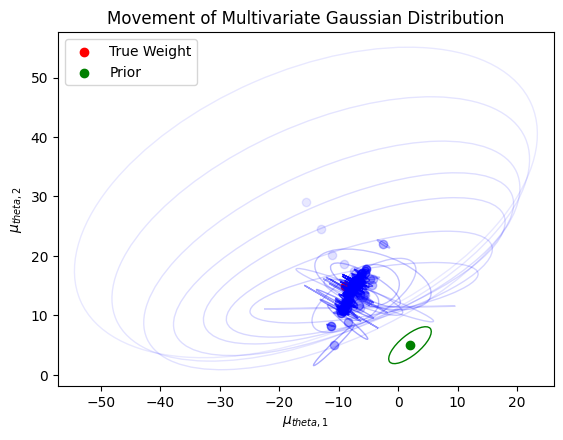

In [53]:
# Define the mean and covariance matrices for each step
mean_list = [true_weights, mean_prior]
cov_list = [np.var(y) * np.array([[1, 0], [0, 1]]), A_prior @ A_prior.T]

# Plotting parameters
colors = ['r', 'g']
labels = ['True Weight', 'Prior']
alphas = [1, 1]
for i in range(len(xs)):
    mean_list.append(xs[i][0:2])
    A = np.array([xs[i][2:4], xs[i][4:6]])
    cov_list.append(A @ A.T)
    colors.append('b')
    labels.append(None)
    alphas.append((i+7)/(len(xs)+7))

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the ellipses for each step
for mean, cov, color, label, alpha in zip(mean_list, cov_list, colors, labels, alphas):
    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    #print("label", label)
    #print(eigenvalues)

    # Compute the ellipse properties
    width = 2 * np.sqrt(eigenvalues[0])
    height = 2 * np.sqrt(eigenvalues[1])
    max_eigenvalue_idx = np.argmax(eigenvalues)
    max_eigenvector = eigenvectors[:, max_eigenvalue_idx]
    angle = np.degrees(np.arctan2(max_eigenvector[1], max_eigenvector[0]))

    # Create the ellipse patch
    #print(width, height)
    ellipse = Ellipse(mean, width=width, height=height, angle=angle, edgecolor=color, facecolor='none', alpha=alpha)
    if not label == 'True Weight':
        ax.add_patch(ellipse)
    ax.scatter(mean[0], mean[1], c=color, alpha=alpha, label=label)

ax.set_aspect("equal")
# Add a legend
ax.legend()

# Set labels and title
ax.set_xlabel('$\mu_{theta ,1}$')
ax.set_ylabel('$\mu_{theta ,2}$')
ax.set_title('Movement of Multivariate Gaussian Distribution')

# Show the plot
plt.show()

In [ ]:
plt.plot(list(range(len(xs))), [np.linalg.norm(grad(function_to_optimize)(x)) for x in xs])

Text(0.5, 1.0, 'Distance to minimum over time (300 datapoints)')

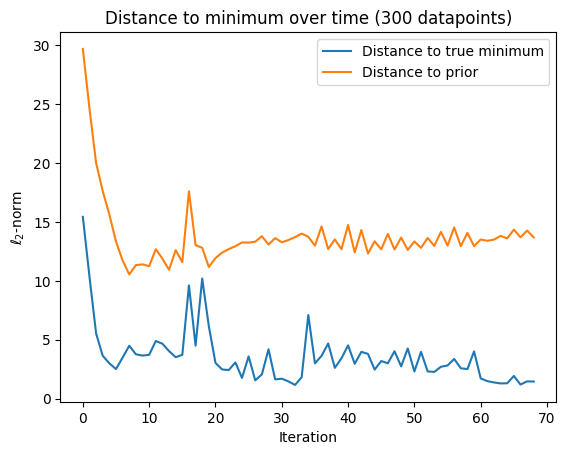

In [54]:
plt.plot(list(range(len(xs))), [np.linalg.norm(true_weights - x[0:2]) for x in xs], label='Distance to true minimum')
plt.plot(list(range(len(xs))), [np.linalg.norm(mean_prior - x[0:2]) for x in xs], label='Distance to prior')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('$\ell_2$-norm')
plt.title('Distance to minimum over time (300 datapoints)')